In [3]:
from watclaimdata import test_df,train_df,valid_df

import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re
import pandas as pd

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

In [10]:
train_df.tail()

,claim,id,rating,original_rating
26971,"If an individual is determined ""to commit suic...",26972,1,barely-true
26972,Former NBA star said modern basketball players...,26973,0,false
26973,"""Since Debbie Halvorson has been in politics, ...",26974,1,half-true
26974,"President Barack Obama ""had the legal authorit...",26975,2,true
26975,Photograph of a Congress worker protesting aga...,26976,0,false


<AxesSubplot:>

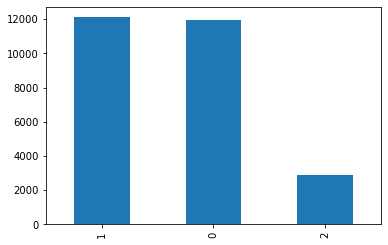

In [8]:
train_df['rating'].value_counts().plot(kind='bar')

In [9]:
# check version number
import imblearn
print(imblearn.__version__)

0.9.0


NearMiss-3 selects the closest examples from the majority class for each minority class.

The n_neighbors_ver3 argument determines the number of examples to select for each minority example, although the desired balancing ratio set via sampling_strategy will filter this to achieve the desired balance.

In [102]:
X = train_df.iloc[:,1:2]
X.shape

(26976, 1)

In [103]:
y = train_df['rating']
y.shape

(26976,)

In [112]:
valid_df['indx'] = valid_df.index

In [115]:
valid_df.head()

,claim,id,rating,original_rating,new_rating,indx
0,"Video shows that ""Joe Biden participated in 'B...",26977,0,false,false,0
1,"""While Act 10 allowed (Milwaukee County) to sa...",26978,1,half-true,misleading,1
2,"""In Massachusetts, Biden’s vote exceeded exit ...",26979,0,false,false,2
3,Reliance supplying Jio Atta after farm bills w...,26980,0,false,false,3
4,Photo of maulvi and MP Shafiqur Rahman Virk pe...,26981,0,false,false,4


In [114]:
X_v = valid_df[['indx']]
y_v = valid_df['rating']
X_v.shape

(3372, 1)

In [116]:
# define the undersampling method
# undersample = NearMiss(version=3)

from imblearn.under_sampling import NearMiss


# define the undersampling method
undersample = NearMiss(n_neighbors_ver3=3)
# transform the dataset
X_near, y_near = undersample.fit_resample(X, y.ravel())
Xv_near, yv_near = undersample.fit_resample(X_v, y_v.ravel())


In [117]:
print("After Undersampling, counts of label '1': {}".format(sum(y_near == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_near == 0))) 
print("After Undersampling, counts of label '2': {}".format(sum(y_near == 2))) 

After Undersampling, counts of label '1': 2894
After Undersampling, counts of label '0': 2894
After Undersampling, counts of label '2': 2894


In [118]:
near_idx = X_near['id'].apply(lambda x: x-1).tolist()
train_near_df = train_df.loc[near_idx]

In [120]:
near_v_idx = Xv_near['indx'].tolist()
valid_near_df = valid_df.loc[near_v_idx]

In [121]:
train_near_df['rating'].unique()

array([0, 1, 2])

In [122]:
train_near_df[train_near_df['rating'] == 0][:5]

,claim,id,rating,original_rating
40,Indians in Spain celebrating Ram Mandir constr...,41,0,false
419,"Says ""Nancy Pelosi came out in favor of MS-13.""",420,0,false
874,Muslims punished for breaking lockdown in India,875,0,false
1629,Photo of Narendra Modi's mother in an auto-ric...,1630,0,false
1705,"President Donald Trump’s budget ""threatened to...",1706,0,false


In [123]:
train_near_df[train_near_df['rating'] == 1][:5]

,claim,id,rating,original_rating
1008,"The number of people who ""believe in socialism...",1009,1,half-true
6412,An image shows animals burning in the Australi...,6413,1,barely-true
7457,"Donald Trump would ""engage in a risky scheme t...",7458,1,barely-true
7635,A photograph shows a nude man walking the runw...,7636,1,miscaptioned
8675,Anyone bringing supplies to DAPL protesters at...,8676,1,mostly true


In [124]:
train_near_df[train_near_df['rating'] == 2][:5]

,claim,id,rating,original_rating
13,"Says that U.S. Rep. Allen West is ""a constitue...",14,2,true
14,"""The average margin of victory in the House of...",15,2,true
25,"""Not a single Democrat opposed Neil Gorsuch's ...",26,2,true
28,"Ted Livingston, the CEO of Kik Interactive, an...",29,2,true
31,There are cities and counties in Georgia that ...,32,2,true


In [126]:
train_near_df['new_rating'] = np.where(train_near_df['rating'] == 0,'false',np.where(train_near_df['rating'] == 1,'misleading',np.where(train_near_df['rating'] == 2,'true','')))
train_near_df['new_rating'].unique()

test_df['new_rating'] = np.where(test_df['rating'] == 0,'false',np.where(test_df['rating'] == 1,'misleading',np.where(test_df['rating'] == 2,'true','')))
valid_near_df['new_rating'] = np.where(valid_near_df['rating'] == 0,'false',np.where(valid_near_df['rating'] == 1,'misleading',np.where(valid_near_df['rating'] == 2,'true','')))



In [127]:

dummy_train_y = np.array(pd.get_dummies(train_near_df['new_rating']))
dummy_test_y = np.array(pd.get_dummies(test_df['new_rating']))
dummy_valid_y = np.array(pd.get_dummies(valid_near_df['new_rating']))


In [128]:
nltk.download('word2vec_sample')
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = KeyedVectors.load_word2vec_format(datapath(word2vec_sample), binary=False)

EMBEDDING_DIM = len(model['university'])      

# initialize embedding matrix and word-to-id map:  
embedding_matrix = np.zeros((len(model) + 1, EMBEDDING_DIM))  
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.index_to_key):
    embedding_vector = model[word]

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

[nltk_data] Downloading package word2vec_sample to
[nltk_data]     /Users/peeti_mac/nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


In [129]:
train_near_df['claim'].values.tolist()[:4]

['Indians in Spain celebrating Ram Mandir construction',
 'Says "Nancy Pelosi came out in favor of MS-13."',
 'Muslims punished for breaking lockdown in India',
 "Photo of Narendra Modi's mother in an auto-rickshaw is photoshopped"]

In [130]:
np.array(train_near_df['rating'].values.tolist())[:4]

array([0, 0, 0, 0])

In [131]:
train_examples = train_near_df['claim'].values.tolist()
train_examples = tf.convert_to_tensor(train_examples)
train_labels = np.array(train_near_df['rating'].values.tolist())
test_examples = test_df['claim'].values.tolist()
test_examples = tf.convert_to_tensor(test_examples)
test_labels = np.array(test_df['rating'].values.tolist())
val_examples = valid_near_df['claim'].values.tolist()
val_examples = tf.convert_to_tensor(val_examples)
val_labels = np.array(valid_near_df['rating'].values.tolist())

# print('Train data contains {} with labels of {}'.format(train_examples.shape[0],train_labels['rating'].unique()))

In [132]:
train_examples[:4]

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b'Indians in Spain celebrating Ram Mandir construction',
       b'Says "Nancy Pelosi came out in favor of MS-13."',
       b'Muslims punished for breaking lockdown in India',
       b"Photo of Narendra Modi's mother in an auto-rickshaw is photoshopped"],
      dtype=object)>

In [133]:
train_labels[:4]

array([0, 0, 0, 0])

In [134]:
train_labels.shape

(8682,)

In [135]:
# tf.convert_to_tensor(train_examples)

In [139]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples)
test_tokens = tokenizer.tokenize(val_examples)

In [140]:
train_tokens[0]

<tf.Tensor: shape=(7,), dtype=string, numpy=
array([b'Indians', b'in', b'Spain', b'celebrating', b'Ram', b'Mandir',
       b'construction'], dtype=object)>

In [141]:
MAX_SEQUENCE_LENGTH = 128

def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])
            
        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with uknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding

        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)
            
        if i % 5000 == 0:
            print('Examples processed: ', i)
        
    print('Total examples: ', i)

    return np.array(texts_vocab_ids)

In [142]:
train_input = docs_to_vocab_ids(train_tokens)
test_input = docs_to_vocab_ids(test_tokens)

train_labels = np.array(train_labels)
test_labels = np.array(val_labels)

Examples processed:  0
Examples processed:  5000
Total examples:  8681
Examples processed:  0
Total examples:  1079


In [143]:
train_input[:4]

array([[11646, 16915, 41348, 41369, 43981, 43981, 13640, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
      

In [144]:
train_labels[:4]

array([0, 0, 0, 0])

In [145]:
def build_ann_model(num_classes, embeddings_trainable=False):
    an_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    
    an_embedding_layer = Embedding(embedding_matrix.shape[0],
                                   embedding_matrix.shape[1],
                                   embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                   input_length=MAX_SEQUENCE_LENGTH,
                                   trainable=embeddings_trainable)
    
    an_embeddings = an_embedding_layer(an_input_layer)
    
    an_avg_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1), name='averaging')(an_embeddings)
    
    an_classification = tf.keras.layers.Dense(num_classes, 
                                              activation='softmax', 
                                              name='an_classification')(an_avg_embeddings)
    
    an_model = tf.keras.models.Model(inputs=an_input_layer, outputs=[an_classification])
    
    
    an_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                        beta_1=0.9,
                                                        beta_2=0.999,
                                                        epsilon=1e-07,
                                                        amsgrad=False,
                                                        name='Adam'),
                     metrics='accuracy')
    return an_model

In [146]:
ann_model = build_ann_model(3)
ann_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 128, 300)          13194600  
                                                                 
 averaging (Lambda)          (None, 300)               0         
                                                                 
 an_classification (Dense)   (None, 3)                 903       
                                                                 
Total params: 13195503 (50.34 MB)
Trainable params: 903 (3.53 KB)
Non-trainable params: 13194600 (50.33 MB)
_________________________________________________________________


In [148]:
ann_history = ann_model.fit(train_input,
                          dummy_train_y,
                          validation_data=(test_input, dummy_valid_y),
                          batch_size=32,
                          epochs=20
                          )

Epoch 1/20
272/272 [==============================] - 1s 3ms/step - loss: 1.0924 - accuracy: 0.4163 - val_loss: 1.0915 - val_accuracy: 0.4306
Epoch 2/20
272/272 [==============================] - 1s 2ms/step - loss: 1.0889 - accuracy: 0.4448 - val_loss: 1.0887 - val_accuracy: 0.4278
Epoch 3/20
272/272 [==============================] - 1s 2ms/step - loss: 1.0858 - accuracy: 0.4474 - val_loss: 1.0862 - val_accuracy: 0.4185
Epoch 4/20
272/272 [==============================] - 1s 2ms/step - loss: 1.0830 - accuracy: 0.4431 - val_loss: 1.0840 - val_accuracy: 0.4157
Epoch 5/20
272/272 [==============================] - 1s 2ms/step - loss: 1.0805 - accuracy: 0.4489 - val_loss: 1.0821 - val_accuracy: 0.4194
Epoch 6/20
272/272 [==============================] - 1s 2ms/step - loss: 1.0783 - accuracy: 0.4479 - val_loss: 1.0804 - val_accuracy: 0.4241
Epoch 7/20
272/272 [==============================] - 1s 2ms/step - loss: 1.0762 - accuracy: 0.4517 - val_loss: 1.0788 - val_accuracy: 0.4194
Epoch 

In [149]:
def build_dan_model(num_classes, hidden_layer_dims, dropout_rate, embeddings_trainable=False):
    dan_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    dan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    dan_embeddings = dan_embedding_layer(dan_input_layer)
    dan_avg_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1),
                                                name='averaging')(dan_embeddings)
    last_hidden_output = dan_avg_embeddings

    for i, h_dim in enumerate(hidden_layer_dims):
        last_hidden_output = tf.keras.layers.Dense(h_dim, activation='relu',
                                                   name='dan_hidden_%d' % i)(last_hidden_output)
        last_hidden_output = tf.keras.layers.Dropout(dropout_rate)(last_hidden_output)
    
    dan_classification = tf.keras.layers.Dense(3,
                                               activation='softmax',
                                               name='dan_classification')(last_hidden_output)
    
    dan_model = tf.keras.models.Model(inputs=dan_input_layer, outputs=[dan_classification])
    dan_model.compile(loss='categorical_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                         beta_1=0.9,
                                                         beta_2=0.999,
                                                         epsilon=1e-07,
                                                         amsgrad=False,
                                                         name='Adam'),
                      metrics='accuracy')
    return dan_model

python(80493) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80494) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


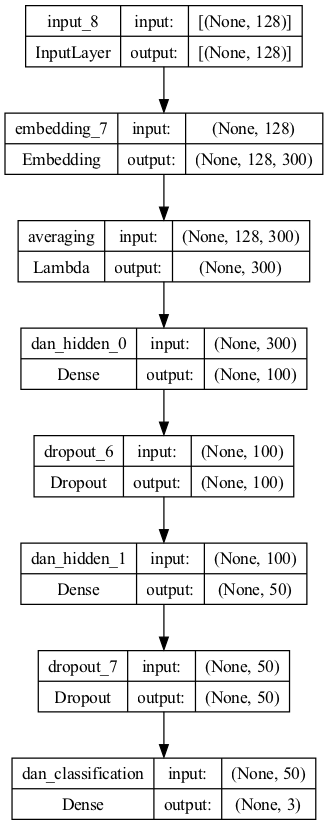

In [150]:
# Now call our function to create a DAN model, and show the model diagram

hidden_layer_sizes = [100, 50]
dropout_rate = 0.5
num_classes = 3

dan_model = build_dan_model(num_classes, hidden_layer_sizes, dropout_rate)
keras.utils.plot_model(dan_model, show_shapes=True, dpi=90)

In [151]:
dan_history = dan_model.fit(train_input,
                          dummy_train_y,
                          validation_data=(test_input, dummy_valid_y),
                          batch_size=32,
                          epochs=20
                            )

Epoch 1/20
272/272 [==============================] - 2s 4ms/step - loss: 1.0916 - accuracy: 0.3825 - val_loss: 1.0806 - val_accuracy: 0.4204
Epoch 2/20
272/272 [==============================] - 1s 3ms/step - loss: 1.0718 - accuracy: 0.4118 - val_loss: 1.0687 - val_accuracy: 0.4194
Epoch 3/20
272/272 [==============================] - 1s 3ms/step - loss: 1.0604 - accuracy: 0.4248 - val_loss: 1.0601 - val_accuracy: 0.4296
Epoch 4/20
272/272 [==============================] - 1s 3ms/step - loss: 1.0519 - accuracy: 0.4372 - val_loss: 1.0526 - val_accuracy: 0.4287
Epoch 5/20
272/272 [==============================] - 1s 2ms/step - loss: 1.0456 - accuracy: 0.4464 - val_loss: 1.0438 - val_accuracy: 0.4519
Epoch 6/20
272/272 [==============================] - 1s 3ms/step - loss: 1.0360 - accuracy: 0.4598 - val_loss: 1.0376 - val_accuracy: 0.4648
Epoch 7/20
272/272 [==============================] - 1s 3ms/step - loss: 1.0331 - accuracy: 0.4622 - val_loss: 1.0359 - val_accuracy: 0.4796
Epoch 

In [152]:
# 4-window plot of loss and accuracy for two models, for comparison

def make_plot(axs,
              model_history1, 
              model_history2, 
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[metric])
            ax1.plot(model_history.history['val_%s' % metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

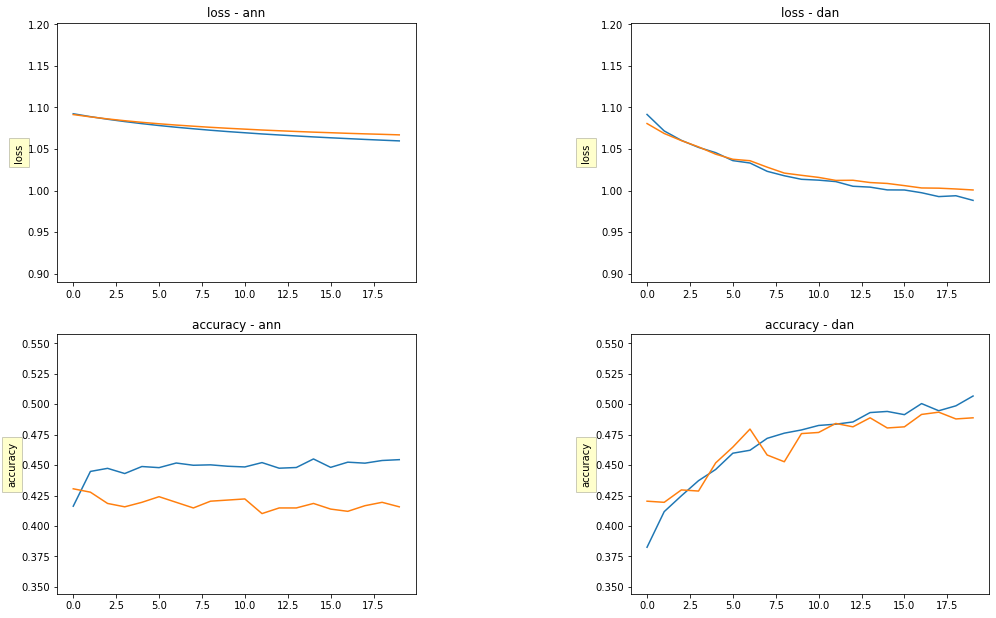

In [153]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          ann_history,
          dan_history,
          model_1_name='ann',
          model_2_name='dan')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

# CNN

In [154]:
def build_cnn_model(num_classes, num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    cnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)
    
    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(conv_output)

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
    
    cnn_prediction = keras.layers.Dense(num_classes, activation='softmax')(last_hidden_output)

    cnn_model = keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
    cnn_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return cnn_model

In [155]:
# Now specify model hyperparameters and call the function to create a CNN model

num_classes = 3
num_filters = [100, 100, 50, 25]
kernel_sizes = [3, 4, 5, 10]
dense_layer_dims = [100, 50]
dropout_rate = 0.5

cnn_model = build_cnn_model(num_classes, num_filters, kernel_sizes, dense_layer_dims, dropout_rate)

In [156]:
cnn_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 embedding_8 (Embedding)     (None, 128, 300)             1319460   ['input_9[0][0]']             
                                                          0                                       
                                                                                                  
 conv1d_4 (Conv1D)           (None, 126, 100)             90100     ['embedding_8[0][0]']         
                                                                                                  
 conv1d_5 (Conv1D)           (None, 125, 100)             120100    ['embedding_8[0][0]']   

In [157]:
cnn_history = cnn_model.fit(train_input,
                          dummy_train_y,
                          validation_data=(test_input, dummy_valid_y),
                          batch_size=32,
                          epochs=5
                            )

Epoch 1/5
272/272 [==============================] - 20s 68ms/step - loss: 1.0590 - accuracy: 0.4232 - val_loss: 1.0283 - val_accuracy: 0.4694
Epoch 2/5
272/272 [==============================] - 17s 64ms/step - loss: 0.9894 - accuracy: 0.5023 - val_loss: 1.0135 - val_accuracy: 0.4667
Epoch 3/5
272/272 [==============================] - 17s 63ms/step - loss: 0.9248 - accuracy: 0.5508 - val_loss: 0.9956 - val_accuracy: 0.4926
Epoch 4/5
272/272 [==============================] - 17s 63ms/step - loss: 0.8258 - accuracy: 0.6184 - val_loss: 1.0377 - val_accuracy: 0.4685
Epoch 5/5
272/272 [==============================] - 18s 64ms/step - loss: 0.7197 - accuracy: 0.6850 - val_loss: 1.0812 - val_accuracy: 0.4870


# RNN

In [158]:
def build_rnn_model(num_classes, rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=True):
    rnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    rnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    rnn_embeddings = rnn_embedding_layer(rnn_input_layer)

    # only return the last output from the RNN calculation 
    rnn_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM')\
        (rnn_embeddings)
    last_hidden_output = rnn_output
    
    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)
    
    rnn_prediction = keras.layers.Dense(num_classes, activation='softmax')(last_hidden_output)

    rnn_model = keras.Model(inputs=rnn_input_layer, outputs=rnn_prediction)
    rnn_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return rnn_model

python(80523) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80524) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


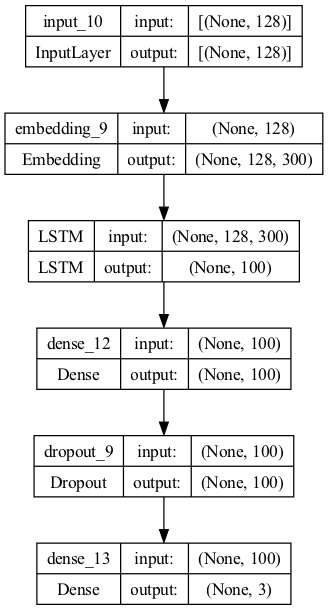

In [159]:
rnn_dim = 100
dense_layer_dims = [100]
dropout_rate = 0.5
num_classes = 3
rnn_model = build_rnn_model(num_classes,
                            rnn_dim,
                            dense_layer_dims,
                            dropout_rate,
                            embeddings_trainable=False)
keras.utils.plot_model(rnn_model, show_shapes=True, dpi=90)

In [160]:
rnn_history = rnn_model.fit(train_input,
                          dummy_train_y,
                          validation_data=(test_input, dummy_valid_y),
                          batch_size=32,
                          epochs=5
                            )

Epoch 1/5
272/272 [==============================] - 25s 85ms/step - loss: 1.0992 - accuracy: 0.3378 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 2/5
272/272 [==============================] - 18s 65ms/step - loss: 1.0990 - accuracy: 0.3339 - val_loss: 1.0988 - val_accuracy: 0.3333
Epoch 3/5
272/272 [==============================] - 18s 67ms/step - loss: 1.0991 - accuracy: 0.3261 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 4/5
272/272 [==============================] - 18s 66ms/step - loss: 1.0990 - accuracy: 0.3315 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 5/5
272/272 [==============================] - 19s 68ms/step - loss: 1.0987 - accuracy: 0.3267 - val_loss: 1.0986 - val_accuracy: 0.3333


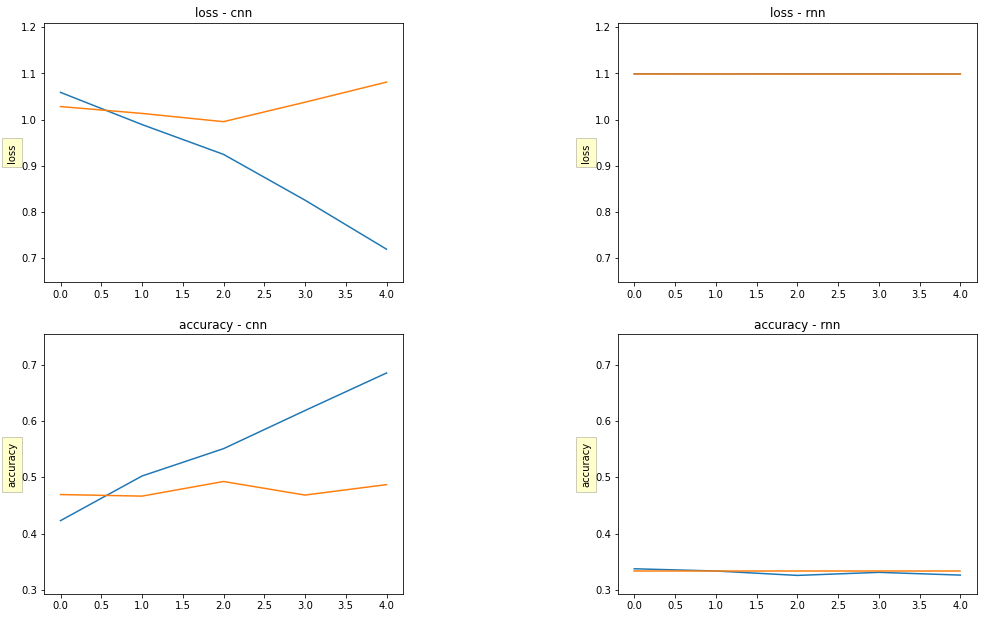

In [161]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          cnn_history, 
          rnn_history, 
          model_1_name='cnn',
          model_2_name='rnn')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

# Stacked RNN

In [162]:
def build_stacked_rnn_model(num_classes, rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    rnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    rnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    rnn_embeddings = rnn_embedding_layer(rnn_input_layer)

    # Now do the stacked one
    #first one is called sequence output and change return_seq = True
    rnn_seq_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=True, return_state=False, name='LSTM1')\
        (rnn_embeddings)
    
    rnn_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM2')\
        (rnn_seq_output) # calc the seq here
    last_hidden_output = rnn_output
    
    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)
    
    rnn_prediction = keras.layers.Dense(num_classes, activation='softmax')(last_hidden_output)

    rnn_model = keras.Model(inputs=rnn_input_layer, outputs=rnn_prediction)
    rnn_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return rnn_model

In [163]:
rnn_dim = 100
dense_layer_dims = [100]
dropout_rate = 0.5
num_classes = 3

stack_rnn_model = build_stacked_rnn_model(num_classes, 
                                          rnn_dim,
                                            dense_layer_dims,
                                            dropout_rate,
                                            embeddings_trainable=False)

In [164]:
stack_rnn_history = stack_rnn_model.fit(train_input,
                          dummy_train_y,
                          validation_data=(test_input, dummy_valid_y),
                          batch_size=32,
                          epochs=5
                            )

Epoch 1/5
272/272 [==============================] - 39s 136ms/step - loss: 1.0992 - accuracy: 0.3344 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 2/5
272/272 [==============================] - 33s 121ms/step - loss: 1.0991 - accuracy: 0.3322 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 3/5
272/272 [==============================] - 33s 122ms/step - loss: 1.0992 - accuracy: 0.3252 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 4/5
272/272 [==============================] - 34s 124ms/step - loss: 1.0989 - accuracy: 0.3361 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 5/5
272/272 [==============================] - 35s 129ms/step - loss: 1.0990 - accuracy: 0.3374 - val_loss: 1.0986 - val_accuracy: 0.3333


# BiDirectional RNN

In [165]:
def build_bidirectional_rnn_model(num_classes, rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    rnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    rnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    rnn_embeddings = rnn_embedding_layer(rnn_input_layer)

    # Now do the Bidirectional one
    #first one is called sequence output and change return_seq = True
    rnn_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM1'))\
        (rnn_embeddings)
    
    last_hidden_output = rnn_output
    
    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)
    
    rnn_prediction = keras.layers.Dense(num_classes, activation='softmax')(last_hidden_output)

    rnn_model = keras.Model(inputs=rnn_input_layer, outputs=rnn_prediction)
    rnn_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',  
                      metrics=['accuracy'])
    return rnn_model

In [166]:
rnn_dim = 100
dense_layer_dims = [100]
dropout_rate = 0.5
num_classes = 3

bi_rnn_model = build_bidirectional_rnn_model(num_classes,
                                             rnn_dim,
                                            dense_layer_dims,
                                            dropout_rate,
                                            embeddings_trainable=False)

In [167]:
bi_rnn_history = bi_rnn_model.fit(train_input,
                          dummy_train_y,
                          validation_data=(test_input, dummy_valid_y),
                          batch_size=32,
                          epochs=5
                            )

Epoch 1/5
272/272 [==============================] - 37s 128ms/step - loss: 1.0456 - accuracy: 0.4394 - val_loss: 1.0169 - val_accuracy: 0.4861
Epoch 2/5
272/272 [==============================] - 33s 121ms/step - loss: 0.9976 - accuracy: 0.4916 - val_loss: 1.0054 - val_accuracy: 0.4935
Epoch 3/5
272/272 [==============================] - 34s 125ms/step - loss: 0.9794 - accuracy: 0.5088 - val_loss: 1.0072 - val_accuracy: 0.4759
Epoch 4/5
272/272 [==============================] - 36s 133ms/step - loss: 0.9618 - accuracy: 0.5179 - val_loss: 1.0176 - val_accuracy: 0.4861
Epoch 5/5
272/272 [==============================] - 35s 128ms/step - loss: 0.9475 - accuracy: 0.5336 - val_loss: 1.0131 - val_accuracy: 0.4898


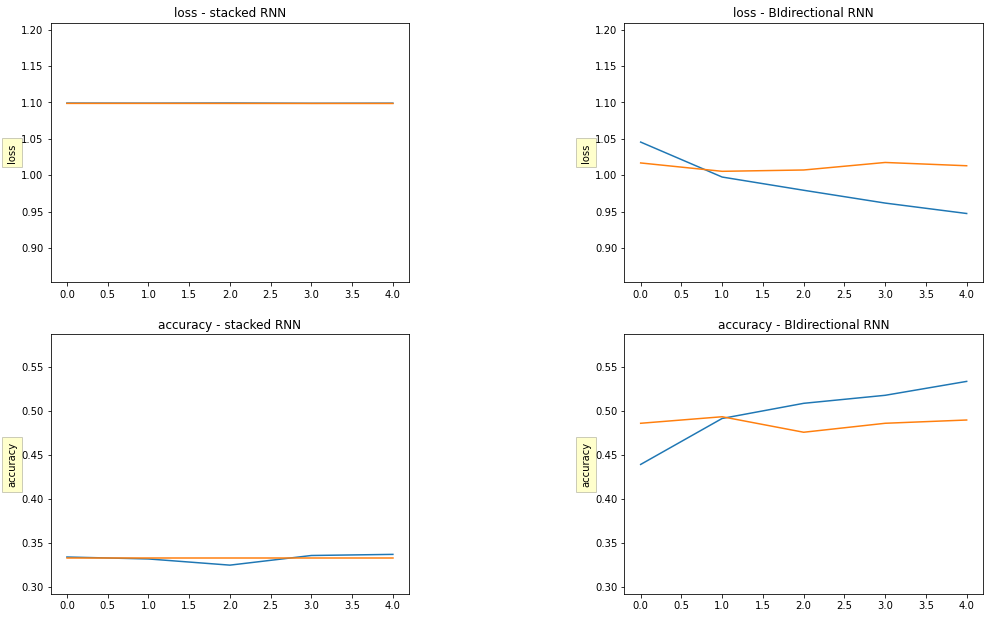

In [168]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          stack_rnn_history, 
          bi_rnn_history, 
          model_1_name='stacked RNN',
          model_2_name='BIdirectional RNN')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()